In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms, utils
from torchvision.io import read_file, decode_jpeg, decode_png, ImageReadMode
import torchvision.transforms as T
import matplotlib.pyplot as plt
from torchvision.io import read_image
import os

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
# DATASET
import os

# read dataset for u-net
class Dataset(Dataset):
    def __init__(self, data_dir, label_dir):
        self.data_dir = data_dir
        self.label_dir = label_dir
        self.files = [os.path.splitext(f)[0] for f in os.listdir(data_dir)]
        self.transform = T.Resize((512, 512))

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        file_name = self.files[idx]
        # read image
        image = read_image(os.path.join(self.data_dir, file_name + ".png"), mode=ImageReadMode.RGB)
        
        # read mask
        mask = read_image(os.path.join(self.label_dir, file_name + ".png"), mode=ImageReadMode.GRAY)
        
        # resize
        image = self.transform(image)
        mask = self.transform(mask)
        
        image = torch.tensor(image, dtype=torch.float32)
        mask = torch.tensor(mask, dtype=torch.float32)
        
        image = image / 255.0
        mask /= 255.0
        mask = torch.round(mask)

        return image, mask
        

        
ds = Dataset("./data/Synthetic/test", "./data/Synthetic/labels")
ds_loader = DataLoader(ds, batch_size=4)

In [3]:
import torch
import torch.nn as nn

""" Convolutional block:
    It follows a two 3x3 convolutional layer, each followed by a batch normalization and a relu activation.
"""
class conv_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()

        self.conv1 = nn.Conv2d(in_c, out_c, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_c)

        self.conv2 = nn.Conv2d(out_c, out_c, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_c)

        self.relu = nn.ReLU()

    def forward(self, inputs):
        x = self.conv1(inputs)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)

        return x

""" Encoder block:
    It consists of an conv_block followed by a max pooling.
    Here the number of filters doubles and the height and width half after every block.
"""
class encoder_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()

        self.conv = conv_block(in_c, out_c)
        self.pool = nn.MaxPool2d((2, 2))

    def forward(self, inputs):
        x = self.conv(inputs)
        p = self.pool(x)

        return x, p

""" Decoder block:
    The decoder block begins with a transpose convolution, followed by a concatenation with the skip
    connection from the encoder block. Next comes the conv_block.
    Here the number filters decreases by half and the height and width doubles.
"""
class decoder_block(nn.Module):
    def __init__(self, in_c, out_c, has_skip=True):
        super().__init__()
        self.has_skip = has_skip
        self.up = nn.ConvTranspose2d(in_c, out_c, kernel_size=2, stride=2, padding=0)
        conv_in = out_c + out_c if has_skip else out_c
        self.conv = conv_block(conv_in, out_c)

    def forward(self, x, skip=None):
        x = self.up(x)
        if self.has_skip and skip is not None:
            x = torch.cat([x, skip], axis=1)
        x = self.conv(x)
        return x
    

In [4]:
class build_unet(nn.Module):
    def __init__(self, channels=[64, 128, 256, 512], bottleneck=1024, skips=[True, True, True, True]):
        super().__init__()
        
        self.e1 = encoder_block(3, channels[0])
        self.e2 = encoder_block(channels[0], channels[1])
        self.e3 = encoder_block(channels[1], channels[2])
        self.e4 = encoder_block(channels[2], channels[3])
        self.b = conv_block(channels[3], bottleneck)

        self.d1 = decoder_block(bottleneck, channels[3], skips[0])
        self.d2 = decoder_block(channels[3], channels[2], skips[1])
        self.d3 = decoder_block(channels[2], channels[1], skips[2])
        self.d4 = decoder_block(channels[1], channels[0], skips[3])

        self.outputs = nn.Conv2d(channels[0], 1, kernel_size=1, padding=0)

    def forward(self, inputs):
        # Encoder
        s1, p1 = self.e1(inputs)
        s2, p2 = self.e2(p1)
        s3, p3 = self.e3(p2)
        s4, p4 = self.e4(p3)
        
        # Bottleneck
        b = self.b(p4)
        
        # Decoder
        d1 = self.d1(b, s4) if self.d1.has_skip else self.d1(b)
        d2 = self.d2(d1, s3) if self.d2.has_skip else self.d2(d1)
        d3 = self.d3(d2, s2) if self.d3.has_skip else self.d3(d2)
        d4 = self.d4(d3, s1) if self.d4.has_skip else self.d4(d3)
        
        # Classifier
        outputs = self.outputs(d4)
        
        return outputs

    
inputs = torch.randn((2, 3, 512, 512)).to(device)

Training Original model ...


C:\Users\fabio\AppData\Local\Temp\ipykernel_27496\2660411871.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image, dtype=torch.float32)
C:\Users\fabio\AppData\Local\Temp\ipykernel_27496\2660411871.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype=torch.float32)


Batch: 0
Epoch [1/200], Loss: 0.2126
Batch: 0
Epoch [2/200], Loss: 0.3429
Batch: 0
Epoch [3/200], Loss: 0.1536
Batch: 0
Epoch [4/200], Loss: 0.0849
Batch: 0
Epoch [5/200], Loss: 0.0532
Batch: 0
Epoch [6/200], Loss: 0.0452
Batch: 0
Epoch [7/200], Loss: 0.0313
Batch: 0
Epoch [8/200], Loss: 0.0310
Batch: 0
Epoch [9/200], Loss: 0.0292
Batch: 0
Epoch [10/200], Loss: 0.0232
Batch: 0
Epoch [11/200], Loss: 0.0220
Batch: 0
Epoch [12/200], Loss: 0.0178
Batch: 0
Epoch [13/200], Loss: 0.0162
Batch: 0
Epoch [14/200], Loss: 0.0150
Batch: 0
Epoch [15/200], Loss: 0.0113
Batch: 0
Epoch [16/200], Loss: 0.0111
Batch: 0
Epoch [17/200], Loss: 0.0108
Batch: 0
Epoch [18/200], Loss: 0.0093
Batch: 0
Epoch [19/200], Loss: 0.0087
Batch: 0
Epoch [20/200], Loss: 0.0082
Batch: 0
Epoch [21/200], Loss: 0.0070
Batch: 0
Epoch [22/200], Loss: 0.0064
Batch: 0
Epoch [23/200], Loss: 0.0057
Batch: 0
Epoch [24/200], Loss: 0.0050
Batch: 0
Epoch [25/200], Loss: 0.0047
Batch: 0
Epoch [26/200], Loss: 0.0043
Batch: 0
Epoch [27/20

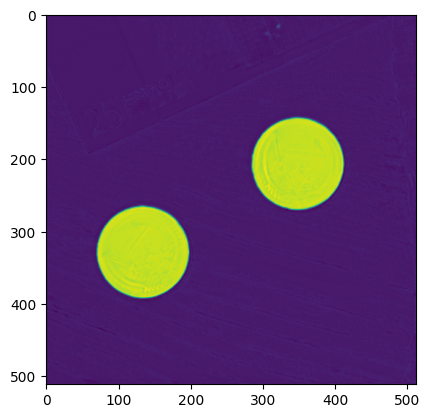

In [5]:
model_original = build_unet(channels=[64, 128, 256, 512], bottleneck=1024, skips=[True, True, True, True]).to(device)
optimizer = optim.Adam(model_original.parameters(), lr=1e-3, weight_decay=1e-5)
criterion = nn.MSELoss()

print("Training Original model ...")
epochs = 200
best_loss = float('inf')
patience = 15
patience_counter = 0

for epoch in range(epochs):
    epoch_loss = 0.0
    num_batches = 0
    
    for idx, (img, mask) in enumerate(ds_loader):
        img, mask = img.to(device), mask.to(device)
        
        output = model_original(img)
        loss = criterion(output, mask)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        num_batches += 1
        print("Batch:", idx)
    
    avg_loss = epoch_loss / num_batches
    print(f'Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}')
    
    if avg_loss < best_loss:
        best_loss = avg_loss
        patience_counter = 0
        torch.save(model_original.state_dict(), "model_original.pth")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break
    
    torch.cuda.empty_cache()

model_original.load_state_dict(torch.load("model_original.pth"))

it = iter(ds_loader)
img, label = next(it)

model_original.eval()

ret = model_original(img.to(device))
plt.imshow(ret[1][0].detach().cpu().numpy())


Training Simplified model (Channel/2)...


C:\Users\fabio\AppData\Local\Temp\ipykernel_27496\2660411871.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image, dtype=torch.float32)
C:\Users\fabio\AppData\Local\Temp\ipykernel_27496\2660411871.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype=torch.float32)


Batch: 0
Epoch [1/200], Loss: 0.3458
Batch: 0
Epoch [2/200], Loss: 0.2537
Batch: 0
Epoch [3/200], Loss: 0.1699
Batch: 0
Epoch [4/200], Loss: 0.1059
Batch: 0
Epoch [5/200], Loss: 0.0884
Batch: 0
Epoch [6/200], Loss: 0.0685
Batch: 0
Epoch [7/200], Loss: 0.0532
Batch: 0
Epoch [8/200], Loss: 0.0424
Batch: 0
Epoch [9/200], Loss: 0.0324
Batch: 0
Epoch [10/200], Loss: 0.0247
Batch: 0
Epoch [11/200], Loss: 0.0198
Batch: 0
Epoch [12/200], Loss: 0.0157
Batch: 0
Epoch [13/200], Loss: 0.0125
Batch: 0
Epoch [14/200], Loss: 0.0105
Batch: 0
Epoch [15/200], Loss: 0.0094
Batch: 0
Epoch [16/200], Loss: 0.0085
Batch: 0
Epoch [17/200], Loss: 0.0080
Batch: 0
Epoch [18/200], Loss: 0.0076
Batch: 0
Epoch [19/200], Loss: 0.0073
Batch: 0
Epoch [20/200], Loss: 0.0071
Batch: 0
Epoch [21/200], Loss: 0.0067
Batch: 0
Epoch [22/200], Loss: 0.0063
Batch: 0
Epoch [23/200], Loss: 0.0058
Batch: 0
Epoch [24/200], Loss: 0.0053
Batch: 0
Epoch [25/200], Loss: 0.0050
Batch: 0
Epoch [26/200], Loss: 0.0045
Batch: 0
Epoch [27/20

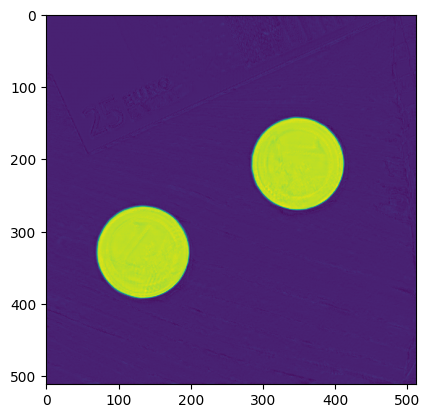

In [6]:
model_simplified = build_unet(channels=[32, 64, 128, 256], bottleneck=512, skips=[True, True, True, True]).to(device)
optimizer = optim.Adam(model_simplified.parameters(), lr=1e-3, weight_decay=1e-5)
criterion = nn.MSELoss()

print("Training Simplified model (Channel/2)...")
epochs = 200
best_loss = float('inf')
patience = 15
patience_counter = 0

for epoch in range(epochs):
    epoch_loss = 0.0
    num_batches = 0
    
    for idx, (img, mask) in enumerate(ds_loader):
        img, mask = img.to(device), mask.to(device)
        
        output = model_simplified(img)
        loss = criterion(output, mask)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        num_batches += 1
        print("Batch:", idx)
    
    avg_loss = epoch_loss / num_batches
    print(f'Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}')
    
    if avg_loss < best_loss:
        best_loss = avg_loss
        patience_counter = 0
        torch.save(model_simplified.state_dict(), "model_simplified.pth")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

    torch.cuda.empty_cache()

model_simplified.load_state_dict(torch.load("model_simplified.pth"))


it = iter(ds_loader)
img, label = next(it)

model_simplified.eval()

ret = model_simplified(img.to(device))
plt.imshow(ret[1][0].detach().cpu().numpy())

Training Simplified model (Channel/4)...


C:\Users\fabio\AppData\Local\Temp\ipykernel_27496\2660411871.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image, dtype=torch.float32)
C:\Users\fabio\AppData\Local\Temp\ipykernel_27496\2660411871.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype=torch.float32)


Batch: 0
Epoch [1/200], Loss: 0.3467
Batch: 0
Epoch [2/200], Loss: 0.2806
Batch: 0
Epoch [3/200], Loss: 0.2313
Batch: 0
Epoch [4/200], Loss: 0.1967
Batch: 0
Epoch [5/200], Loss: 0.1663
Batch: 0
Epoch [6/200], Loss: 0.1401
Batch: 0
Epoch [7/200], Loss: 0.1200
Batch: 0
Epoch [8/200], Loss: 0.0996
Batch: 0
Epoch [9/200], Loss: 0.0837
Batch: 0
Epoch [10/200], Loss: 0.0710
Batch: 0
Epoch [11/200], Loss: 0.0605
Batch: 0
Epoch [12/200], Loss: 0.0496
Batch: 0
Epoch [13/200], Loss: 0.0423
Batch: 0
Epoch [14/200], Loss: 0.0340
Batch: 0
Epoch [15/200], Loss: 0.0280
Batch: 0
Epoch [16/200], Loss: 0.0230
Batch: 0
Epoch [17/200], Loss: 0.0187
Batch: 0
Epoch [18/200], Loss: 0.0152
Batch: 0
Epoch [19/200], Loss: 0.0128
Batch: 0
Epoch [20/200], Loss: 0.0110
Batch: 0
Epoch [21/200], Loss: 0.0095
Batch: 0
Epoch [22/200], Loss: 0.0082
Batch: 0
Epoch [23/200], Loss: 0.0072
Batch: 0
Epoch [24/200], Loss: 0.0065
Batch: 0
Epoch [25/200], Loss: 0.0059
Batch: 0
Epoch [26/200], Loss: 0.0054
Batch: 0
Epoch [27/20

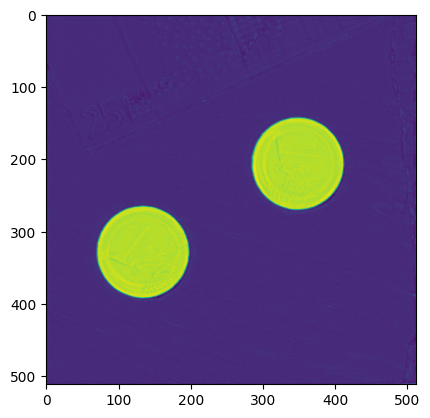

In [7]:
model_simplified_4 = build_unet(channels=[16, 32, 64, 128], bottleneck=256, skips=[True, True, True, True]).to(device)
optimizer = optim.Adam(model_simplified_4.parameters(), lr=1e-3, weight_decay=1e-5)
criterion = nn.MSELoss()

print("Training Simplified model (Channel/4)...")
epochs = 200
best_loss = float('inf')
patience = 15
patience_counter = 0

for epoch in range(epochs):
    epoch_loss = 0.0
    num_batches = 0
    
    for idx, (img, mask) in enumerate(ds_loader):
        img, mask = img.to(device), mask.to(device)
        
        output = model_simplified_4(img)
        loss = criterion(output, mask)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        num_batches += 1
        print("Batch:", idx)
    
    avg_loss = epoch_loss / num_batches
    print(f'Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}')
    
    if avg_loss < best_loss:
        best_loss = avg_loss
        patience_counter = 0
        torch.save(model_simplified_4.state_dict(), "model_simplified_4.pth")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

    torch.cuda.empty_cache()
       
model_simplified_4.load_state_dict(torch.load("model_simplified_4.pth"))

it = iter(ds_loader)
img, label = next(it)

model_simplified_4.eval()

ret = model_simplified_4(img.to(device))
plt.imshow(ret[1][0].detach().cpu().numpy())

Training Simplified model (Channel/8)...


C:\Users\fabio\AppData\Local\Temp\ipykernel_27496\2660411871.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image, dtype=torch.float32)
C:\Users\fabio\AppData\Local\Temp\ipykernel_27496\2660411871.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype=torch.float32)


Batch: 0
Epoch [1/200], Loss: 0.2659
Batch: 0
Epoch [2/200], Loss: 0.2132
Batch: 0
Epoch [3/200], Loss: 0.1769
Batch: 0
Epoch [4/200], Loss: 0.1515
Batch: 0
Epoch [5/200], Loss: 0.1307
Batch: 0
Epoch [6/200], Loss: 0.1138
Batch: 0
Epoch [7/200], Loss: 0.1000
Batch: 0
Epoch [8/200], Loss: 0.0864
Batch: 0
Epoch [9/200], Loss: 0.0748
Batch: 0
Epoch [10/200], Loss: 0.0655
Batch: 0
Epoch [11/200], Loss: 0.0546
Batch: 0
Epoch [12/200], Loss: 0.0478
Batch: 0
Epoch [13/200], Loss: 0.0416
Batch: 0
Epoch [14/200], Loss: 0.0361
Batch: 0
Epoch [15/200], Loss: 0.0317
Batch: 0
Epoch [16/200], Loss: 0.0274
Batch: 0
Epoch [17/200], Loss: 0.0246
Batch: 0
Epoch [18/200], Loss: 0.0216
Batch: 0
Epoch [19/200], Loss: 0.0197
Batch: 0
Epoch [20/200], Loss: 0.0178
Batch: 0
Epoch [21/200], Loss: 0.0158
Batch: 0
Epoch [22/200], Loss: 0.0146
Batch: 0
Epoch [23/200], Loss: 0.0132
Batch: 0
Epoch [24/200], Loss: 0.0123
Batch: 0
Epoch [25/200], Loss: 0.0113
Batch: 0
Epoch [26/200], Loss: 0.0106
Batch: 0
Epoch [27/20

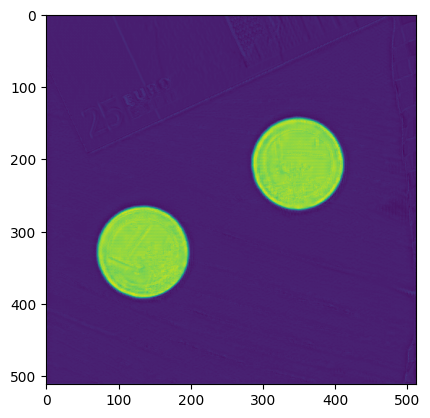

In [8]:
model_simplified_8 = build_unet(channels=[8, 16, 32, 64], bottleneck=128, skips=[True, True, True, True]).to(device)
optimizer = optim.Adam(model_simplified_8.parameters(), lr=1e-3, weight_decay=1e-5)
criterion = nn.MSELoss()

print("Training Simplified model (Channel/8)...")
epochs = 200
best_loss = float('inf')
patience = 15
patience_counter = 0

for epoch in range(epochs):
    epoch_loss = 0.0
    num_batches = 0
    
    for idx, (img, mask) in enumerate(ds_loader):
        img, mask = img.to(device), mask.to(device)
        
        output = model_simplified_8(img)
        loss = criterion(output, mask)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        num_batches += 1
        print("Batch:", idx)
    
    avg_loss = epoch_loss / num_batches
    print(f'Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}')
    
    if avg_loss < best_loss:
        best_loss = avg_loss
        patience_counter = 0
        torch.save(model_simplified_8.state_dict(), "model_simplified_8.pth")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break
        
    torch.cuda.empty_cache()
    
model_simplified_8.load_state_dict(torch.load("model_simplified_8.pth"))

it = iter(ds_loader)
img, label = next(it)

model_simplified_8.eval()

ret = model_simplified_8(img.to(device))
plt.imshow(ret[1][0].detach().cpu().numpy())

Training Simplified model (Channel/16)...
Batch: 0
Epoch [1/200], Loss: 0.3807


C:\Users\fabio\AppData\Local\Temp\ipykernel_27496\2660411871.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image, dtype=torch.float32)
C:\Users\fabio\AppData\Local\Temp\ipykernel_27496\2660411871.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype=torch.float32)


Batch: 0
Epoch [2/200], Loss: 0.3367
Batch: 0
Epoch [3/200], Loss: 0.3035
Batch: 0
Epoch [4/200], Loss: 0.2806
Batch: 0
Epoch [5/200], Loss: 0.2666
Batch: 0
Epoch [6/200], Loss: 0.2556
Batch: 0
Epoch [7/200], Loss: 0.2454
Batch: 0
Epoch [8/200], Loss: 0.2349
Batch: 0
Epoch [9/200], Loss: 0.2242
Batch: 0
Epoch [10/200], Loss: 0.2139
Batch: 0
Epoch [11/200], Loss: 0.2041
Batch: 0
Epoch [12/200], Loss: 0.1949
Batch: 0
Epoch [13/200], Loss: 0.1865
Batch: 0
Epoch [14/200], Loss: 0.1787
Batch: 0
Epoch [15/200], Loss: 0.1715
Batch: 0
Epoch [16/200], Loss: 0.1646
Batch: 0
Epoch [17/200], Loss: 0.1583
Batch: 0
Epoch [18/200], Loss: 0.1523
Batch: 0
Epoch [19/200], Loss: 0.1463
Batch: 0
Epoch [20/200], Loss: 0.1411
Batch: 0
Epoch [21/200], Loss: 0.1357
Batch: 0
Epoch [22/200], Loss: 0.1310
Batch: 0
Epoch [23/200], Loss: 0.1267
Batch: 0
Epoch [24/200], Loss: 0.1230
Batch: 0
Epoch [25/200], Loss: 0.1192
Batch: 0
Epoch [26/200], Loss: 0.1160
Batch: 0
Epoch [27/200], Loss: 0.1129
Batch: 0
Epoch [28/2

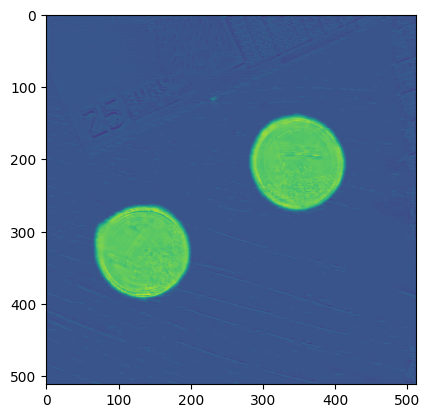

In [9]:
model_simplified_16 = build_unet(channels=[4, 8, 16, 32], bottleneck=64, skips=[True, True, True, True]).to(device)
optimizer = optim.Adam(model_simplified_16.parameters(), lr=1e-3, weight_decay=1e-5)
criterion = nn.MSELoss()

print("Training Simplified model (Channel/16)...")
epochs = 200
best_loss = float('inf')
patience = 15
patience_counter = 0

for epoch in range(epochs):
    epoch_loss = 0.0
    num_batches = 0
    
    for idx, (img, mask) in enumerate(ds_loader):
        img, mask = img.to(device), mask.to(device)
        
        output = model_simplified_16(img)
        loss = criterion(output, mask)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        num_batches += 1
        print("Batch:", idx)
    
    avg_loss = epoch_loss / num_batches
    print(f'Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}')
    
    if avg_loss < best_loss:
        best_loss = avg_loss
        patience_counter = 0
        torch.save(model_simplified_16.state_dict(), "model_simplified_16.pth")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break
    
    torch.cuda.empty_cache()

model_simplified_16.load_state_dict(torch.load("model_simplified_16.pth"))

it = iter(ds_loader)
img, label = next(it)

model_simplified_16.eval()

ret = model_simplified_16(img.to(device))
plt.imshow(ret[1][0].detach().cpu().numpy())

Training Simplified model (Channel/32)...
Batch: 0
Epoch [1/200], Loss: 0.8045


C:\Users\fabio\AppData\Local\Temp\ipykernel_27496\2660411871.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image, dtype=torch.float32)
C:\Users\fabio\AppData\Local\Temp\ipykernel_27496\2660411871.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype=torch.float32)


Batch: 0
Epoch [2/200], Loss: 0.8028
Batch: 0
Epoch [3/200], Loss: 0.8011
Batch: 0
Epoch [4/200], Loss: 0.7994
Batch: 0
Epoch [5/200], Loss: 0.7977
Batch: 0
Epoch [6/200], Loss: 0.7960
Batch: 0
Epoch [7/200], Loss: 0.7944
Batch: 0
Epoch [8/200], Loss: 0.7927
Batch: 0
Epoch [9/200], Loss: 0.7911
Batch: 0
Epoch [10/200], Loss: 0.7894
Batch: 0
Epoch [11/200], Loss: 0.7878
Batch: 0
Epoch [12/200], Loss: 0.7861
Batch: 0
Epoch [13/200], Loss: 0.7845
Batch: 0
Epoch [14/200], Loss: 0.7828
Batch: 0
Epoch [15/200], Loss: 0.7812
Batch: 0
Epoch [16/200], Loss: 0.7796
Batch: 0
Epoch [17/200], Loss: 0.7780
Batch: 0
Epoch [18/200], Loss: 0.7763
Batch: 0
Epoch [19/200], Loss: 0.7747
Batch: 0
Epoch [20/200], Loss: 0.7731
Batch: 0
Epoch [21/200], Loss: 0.7715
Batch: 0
Epoch [22/200], Loss: 0.7699
Batch: 0
Epoch [23/200], Loss: 0.7683
Batch: 0
Epoch [24/200], Loss: 0.7667
Batch: 0
Epoch [25/200], Loss: 0.7651
Batch: 0
Epoch [26/200], Loss: 0.7636
Batch: 0
Epoch [27/200], Loss: 0.7620
Batch: 0
Epoch [28/2

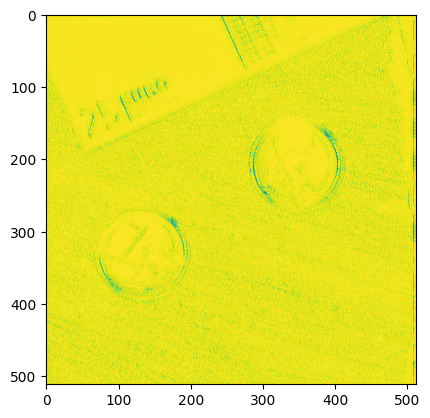

In [10]:
model_simplified_32 = build_unet(channels=[2, 4, 8, 16], bottleneck=32, skips=[True, True, True, True]).to(device)
optimizer = optim.Adam(model_simplified_32.parameters(), lr=1e-4)
criterion = nn.MSELoss()

print("Training Simplified model (Channel/32)...")
epochs = 200
best_loss = float('inf')
patience = 15
patience_counter = 0

for epoch in range(epochs):
    epoch_loss = 0.0
    num_batches = 0
    
    for idx, (img, mask) in enumerate(ds_loader):
        img, mask = img.to(device), mask.to(device)
        
        output = model_simplified_32(img)
        loss = criterion(output, mask)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        num_batches += 1
        print("Batch:", idx)
    
    avg_loss = epoch_loss / num_batches
    print(f'Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}')
    
    if avg_loss < best_loss:
        best_loss = avg_loss
        patience_counter = 0
        torch.save(model_simplified_32.state_dict(), "model_simplified_32.pth")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break
        
    torch.cuda.empty_cache()

model_simplified_32.load_state_dict(torch.load("model_simplified_32.pth"))

it = iter(ds_loader)
img, label = next(it)

model_simplified_32.eval()

ret = model_simplified_32(img.to(device))
plt.imshow(ret[1][0].detach().cpu().numpy())

Training No-Skip model (No skip in last decoder)...


C:\Users\fabio\AppData\Local\Temp\ipykernel_27496\2660411871.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image, dtype=torch.float32)
C:\Users\fabio\AppData\Local\Temp\ipykernel_27496\2660411871.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype=torch.float32)


Batch: 0
Epoch [1/200], Loss: 0.2377
Batch: 0
Epoch [2/200], Loss: 0.4394
Batch: 0
Epoch [3/200], Loss: 0.1835
Batch: 0
Epoch [4/200], Loss: 0.0520
Batch: 0
Epoch [5/200], Loss: 0.0432
Batch: 0
Epoch [6/200], Loss: 0.0244
Batch: 0
Epoch [7/200], Loss: 0.0188
Batch: 0
Epoch [8/200], Loss: 0.0174
Batch: 0
Epoch [9/200], Loss: 0.0144
Batch: 0
Epoch [10/200], Loss: 0.0137
Batch: 0
Epoch [11/200], Loss: 0.0115
Batch: 0
Epoch [12/200], Loss: 0.0101
Batch: 0
Epoch [13/200], Loss: 0.0089
Batch: 0
Epoch [14/200], Loss: 0.0083
Batch: 0
Epoch [15/200], Loss: 0.0081
Batch: 0
Epoch [16/200], Loss: 0.0075
Batch: 0
Epoch [17/200], Loss: 0.0063
Batch: 0
Epoch [18/200], Loss: 0.0057
Batch: 0
Epoch [19/200], Loss: 0.0057
Batch: 0
Epoch [20/200], Loss: 0.0054
Batch: 0
Epoch [21/200], Loss: 0.0048
Batch: 0
Epoch [22/200], Loss: 0.0045
Batch: 0
Epoch [23/200], Loss: 0.0044
Batch: 0
Epoch [24/200], Loss: 0.0042
Batch: 0
Epoch [25/200], Loss: 0.0037
Batch: 0
Epoch [26/200], Loss: 0.0035
Batch: 0
Epoch [27/20

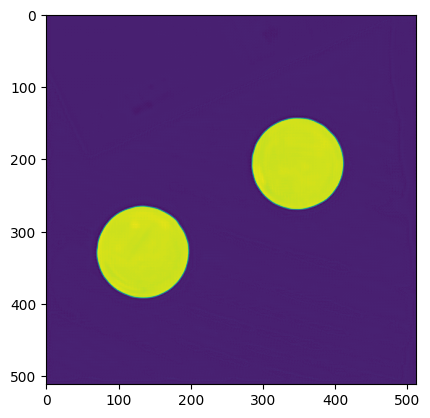

In [11]:
model_no_skip_1 = build_unet(channels=[64, 128, 256, 512], bottleneck=1024, skips=[True, True, True, False]).to(device)
optimizer = optim.Adam(model_no_skip_1.parameters(), lr=1e-3, weight_decay=1e-5)
criterion = nn.MSELoss()

print("Training No-Skip model (No skip in last decoder)...")
epochs = 200
best_loss = float('inf')
patience = 15
patience_counter = 0

for epoch in range(epochs):
    epoch_loss = 0.0
    num_batches = 0
    
    for idx, (img, mask) in enumerate(ds_loader):
        img, mask = img.to(device), mask.to(device)
        
        output = model_no_skip_1(img)
        loss = criterion(output, mask)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        num_batches += 1
        print("Batch:", idx)
    
    avg_loss = epoch_loss / num_batches
    print(f'Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}')
    
    if avg_loss < best_loss:
        best_loss = avg_loss
        patience_counter = 0
        torch.save(model_no_skip_1.state_dict(), "model_no_skip_1.pth")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

    torch.cuda.empty_cache()
        
model_no_skip_1.load_state_dict(torch.load("model_no_skip_1.pth"))

it = iter(ds_loader)
img, label = next(it)

model_no_skip_1.eval()

ret = model_no_skip_1(img.to(device))
plt.imshow(ret[1][0].detach().cpu().numpy())

Training No-Skip model (No skip in last two decoders)...


C:\Users\fabio\AppData\Local\Temp\ipykernel_6996\2660411871.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image, dtype=torch.float32)
C:\Users\fabio\AppData\Local\Temp\ipykernel_6996\2660411871.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype=torch.float32)


Batch: 0
Epoch [1/200], Loss: 0.2514
Batch: 0
Epoch [2/200], Loss: 0.6186
Batch: 0
Epoch [3/200], Loss: 0.1358
Batch: 0
Epoch [4/200], Loss: 0.1117
Batch: 0
Epoch [5/200], Loss: 0.0685
Batch: 0
Epoch [6/200], Loss: 0.0510
Batch: 0
Epoch [7/200], Loss: 0.0292
Batch: 0
Epoch [8/200], Loss: 0.0210
Batch: 0
Epoch [9/200], Loss: 0.0230
Batch: 0
Epoch [10/200], Loss: 0.0173
Batch: 0
Epoch [11/200], Loss: 0.0117
Batch: 0
Epoch [12/200], Loss: 0.0118
Batch: 0
Epoch [13/200], Loss: 0.0124
Batch: 0
Epoch [14/200], Loss: 0.0117
Batch: 0
Epoch [15/200], Loss: 0.0104
Batch: 0
Epoch [16/200], Loss: 0.0095
Batch: 0
Epoch [17/200], Loss: 0.0092
Batch: 0
Epoch [18/200], Loss: 0.0088
Batch: 0
Epoch [19/200], Loss: 0.0080
Batch: 0
Epoch [20/200], Loss: 0.0072
Batch: 0
Epoch [21/200], Loss: 0.0067
Batch: 0
Epoch [22/200], Loss: 0.0066
Batch: 0
Epoch [23/200], Loss: 0.0065
Batch: 0
Epoch [24/200], Loss: 0.0065
Batch: 0
Epoch [25/200], Loss: 0.0065
Batch: 0
Epoch [26/200], Loss: 0.0065
Batch: 0
Epoch [27/20

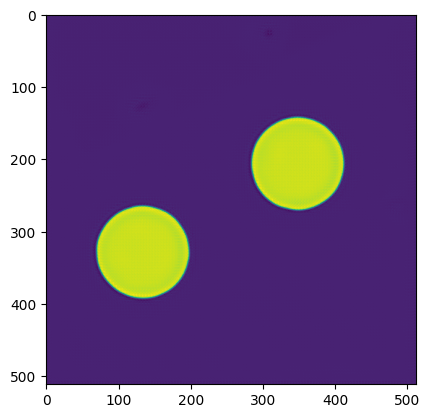

In [5]:
model_no_skip_2 = build_unet(channels=[64, 128, 256, 512], bottleneck=1024, skips=[True, True, False, False]).to(device)
optimizer = optim.Adam(model_no_skip_2.parameters(), lr=1e-3, weight_decay=1e-5)
criterion = nn.MSELoss()

print("Training No-Skip model (No skip in last two decoders)...")
epochs = 200
best_loss = float('inf')
patience = 15
patience_counter = 0

for epoch in range(epochs):
    epoch_loss = 0.0
    num_batches = 0
    
    for idx, (img, mask) in enumerate(ds_loader):
        img, mask = img.to(device), mask.to(device)
        
        output = model_no_skip_2(img)
        loss = criterion(output, mask)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        num_batches += 1
        print("Batch:", idx)
    
    avg_loss = epoch_loss / num_batches
    print(f'Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}')
    
    if avg_loss < best_loss:
        best_loss = avg_loss
        patience_counter = 0
        torch.save(model_no_skip_2.state_dict(), "model_no_skip_2.pth")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break
    
    torch.cuda.empty_cache()

model_no_skip_2.load_state_dict(torch.load("model_no_skip_2.pth"))

it = iter(ds_loader)
img, label = next(it)

model_no_skip_2.eval()

ret = model_no_skip_2(img.to(device))
plt.imshow(ret[1][0].detach().cpu().numpy())

Training No-Skip model (No skip in last three decoders)...


C:\Users\fabio\AppData\Local\Temp\ipykernel_16780\2660411871.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image, dtype=torch.float32)
C:\Users\fabio\AppData\Local\Temp\ipykernel_16780\2660411871.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype=torch.float32)


Batch: 0
Epoch [1/200], Loss: 0.3668
Batch: 0
Epoch [2/200], Loss: 0.6778
Batch: 0
Epoch [3/200], Loss: 0.2552
Batch: 0
Epoch [4/200], Loss: 0.1925
Batch: 0
Epoch [5/200], Loss: 0.1630
Batch: 0
Epoch [6/200], Loss: 0.1417
Batch: 0
Epoch [7/200], Loss: 0.1278
Batch: 0
Epoch [8/200], Loss: 0.1213
Batch: 0
Epoch [9/200], Loss: 0.1226
Batch: 0
Epoch [10/200], Loss: 0.1247
Batch: 0
Epoch [11/200], Loss: 0.1234
Batch: 0
Epoch [12/200], Loss: 0.1215
Batch: 0
Epoch [13/200], Loss: 0.1208
Batch: 0
Epoch [14/200], Loss: 0.1203
Batch: 0
Epoch [15/200], Loss: 0.1192
Batch: 0
Epoch [16/200], Loss: 0.1182
Batch: 0
Epoch [17/200], Loss: 0.1181
Batch: 0
Epoch [18/200], Loss: 0.1182
Batch: 0
Epoch [19/200], Loss: 0.1180
Batch: 0
Epoch [20/200], Loss: 0.1176
Batch: 0
Epoch [21/200], Loss: 0.1172
Batch: 0
Epoch [22/200], Loss: 0.1171
Batch: 0
Epoch [23/200], Loss: 0.1171
Batch: 0
Epoch [24/200], Loss: 0.1170
Batch: 0
Epoch [25/200], Loss: 0.1169
Batch: 0
Epoch [26/200], Loss: 0.1167
Batch: 0
Epoch [27/20

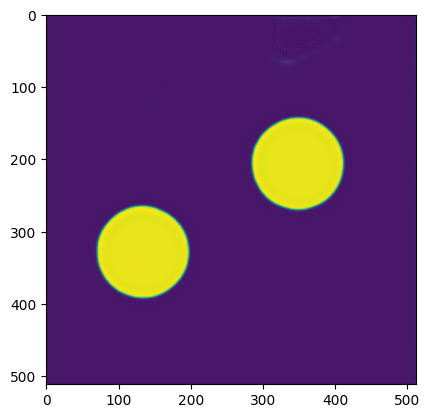

In [5]:
model_no_skip_3 = build_unet(channels=[64, 128, 256, 512], bottleneck=1024, skips=[True, False, False, False]).to(device)
optimizer = optim.Adam(model_no_skip_3.parameters(), lr=1e-3, weight_decay=1e-5)
criterion = nn.MSELoss()

print("Training No-Skip model (No skip in last three decoders)...")
epochs = 200
best_loss = float('inf')
patience = 15
patience_counter = 0

for epoch in range(epochs):
    epoch_loss = 0.0
    num_batches = 0
    
    for idx, (img, mask) in enumerate(ds_loader):
        img, mask = img.to(device), mask.to(device)
        
        output = model_no_skip_3(img)
        loss = criterion(output, mask)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        num_batches += 1
        print("Batch:", idx)
    
    avg_loss = epoch_loss / num_batches
    print(f'Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}')
    
    if avg_loss < best_loss:
        best_loss = avg_loss
        patience_counter = 0
        torch.save(model_no_skip_3.state_dict(), "model_no_skip_3.pth")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

    torch.cuda.empty_cache()

model_no_skip_3.load_state_dict(torch.load("model_no_skip_3.pth"))

it = iter(ds_loader)
img, label = next(it)

model_no_skip_3.eval()

ret = model_no_skip_3(img.to(device))
plt.imshow(ret[1][0].detach().cpu().numpy())

Training No-Skip model (No skip in all decoders)...


C:\Users\fabio\AppData\Local\Temp\ipykernel_21416\2660411871.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image, dtype=torch.float32)
C:\Users\fabio\AppData\Local\Temp\ipykernel_21416\2660411871.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype=torch.float32)


Batch: 0
Epoch [1/200], Loss: 0.2929
Batch: 0
Epoch [2/200], Loss: 0.5896
Batch: 0
Epoch [3/200], Loss: 0.1842
Batch: 0
Epoch [4/200], Loss: 0.1511
Batch: 0
Epoch [5/200], Loss: 0.1404
Batch: 0
Epoch [6/200], Loss: 0.1316
Batch: 0
Epoch [7/200], Loss: 0.1254
Batch: 0
Epoch [8/200], Loss: 0.1222
Batch: 0
Epoch [9/200], Loss: 0.1203
Batch: 0
Epoch [10/200], Loss: 0.1194
Batch: 0
Epoch [11/200], Loss: 0.1191
Batch: 0
Epoch [12/200], Loss: 0.1186
Batch: 0
Epoch [13/200], Loss: 0.1183
Batch: 0
Epoch [14/200], Loss: 0.1171
Batch: 0
Epoch [15/200], Loss: 0.1138
Batch: 0
Epoch [16/200], Loss: 0.1074
Batch: 0
Epoch [17/200], Loss: 0.0972
Batch: 0
Epoch [18/200], Loss: 0.0830
Batch: 0
Epoch [19/200], Loss: 0.0617
Batch: 0
Epoch [20/200], Loss: 0.0494
Batch: 0
Epoch [21/200], Loss: 0.1198
Batch: 0
Epoch [22/200], Loss: 0.0993
Batch: 0
Epoch [23/200], Loss: 0.0948
Batch: 0
Epoch [24/200], Loss: 0.1183
Batch: 0
Epoch [25/200], Loss: 0.1154
Batch: 0
Epoch [26/200], Loss: 0.1032
Batch: 0
Epoch [27/20

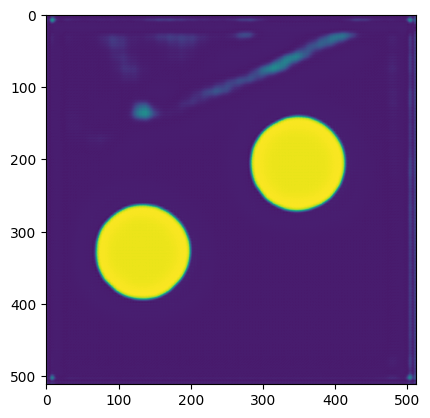

In [5]:
model_no_skip_4 = build_unet(channels=[64, 128, 256, 512], bottleneck=1024, skips=[False, False, False, False]).to(device)
optimizer = optim.Adam(model_no_skip_4.parameters(), lr=1e-3, weight_decay=1e-5)
criterion = nn.MSELoss()

print("Training No-Skip model (No skip in all decoders)...")
epochs = 200
best_loss = float('inf')
patience = 15
patience_counter = 0

for epoch in range(epochs):
    epoch_loss = 0.0
    num_batches = 0
    
    for idx, (img, mask) in enumerate(ds_loader):
        img, mask = img.to(device), mask.to(device)
        
        output = model_no_skip_4(img)
        loss = criterion(output, mask)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        num_batches += 1
        print("Batch:", idx)
    
    avg_loss = epoch_loss / num_batches
    print(f'Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}')
    
    if avg_loss < best_loss:
        best_loss = avg_loss
        patience_counter = 0
        torch.save(model_no_skip_4.state_dict(), "model_no_skip_4.pth")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

    torch.cuda.empty_cache()

model_no_skip_4.load_state_dict(torch.load("model_no_skip_4.pth"))

it = iter(ds_loader)
img, label = next(it)

model_no_skip_4.eval()

ret = model_no_skip_4(img.to(device))
plt.imshow(ret[1][0].detach().cpu().numpy())

C:\Users\fabio\AppData\Local\Temp\ipykernel_21416\2660411871.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image, dtype=torch.float32)
C:\Users\fabio\AppData\Local\Temp\ipykernel_21416\2660411871.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype=torch.float32)


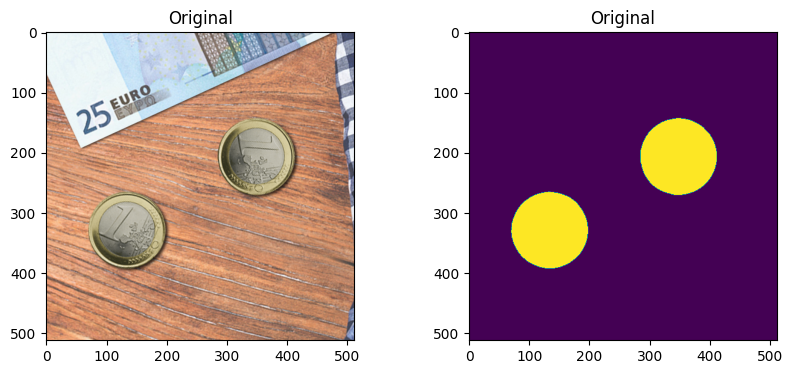

------------------------------


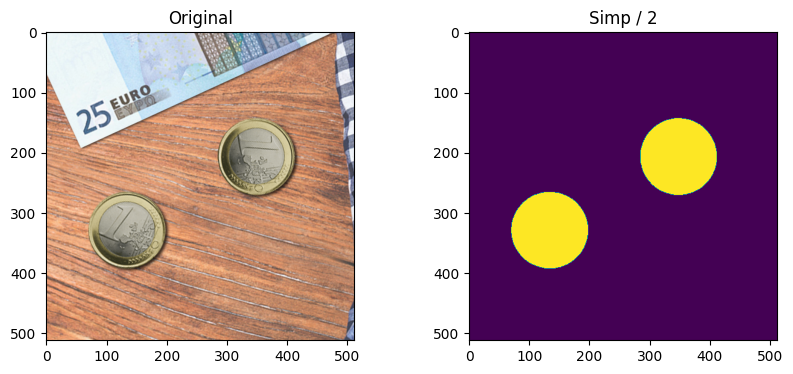

------------------------------


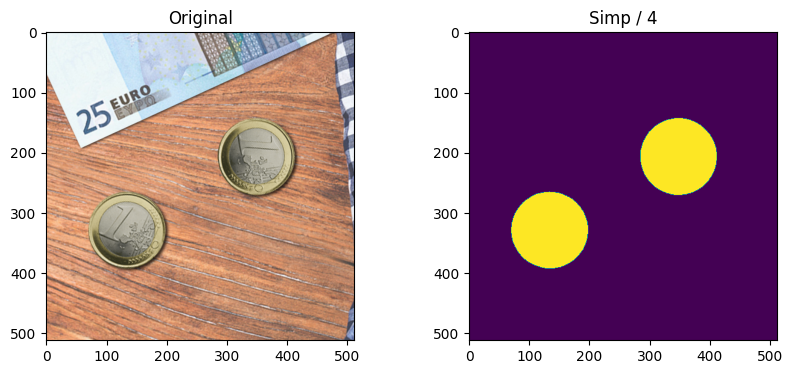

------------------------------


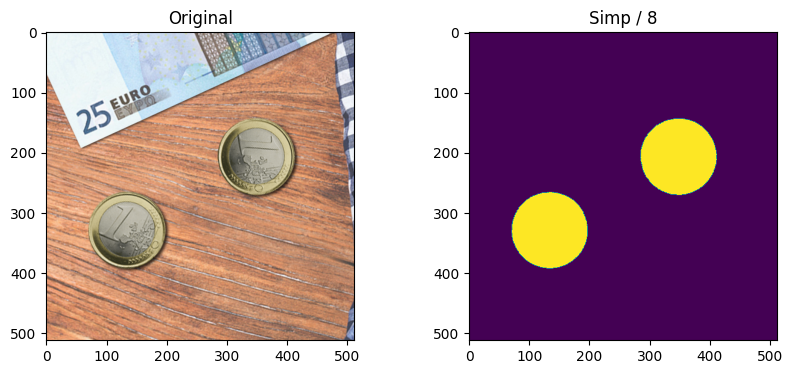

------------------------------


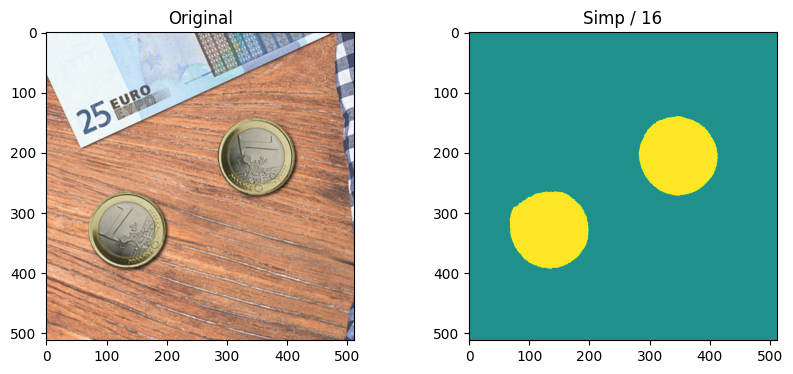

------------------------------


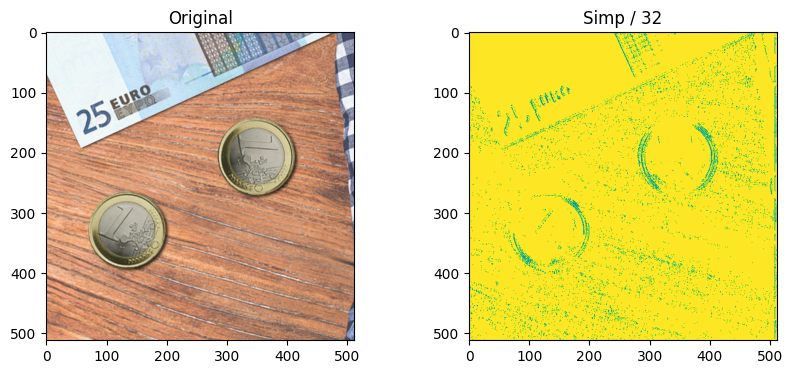

------------------------------


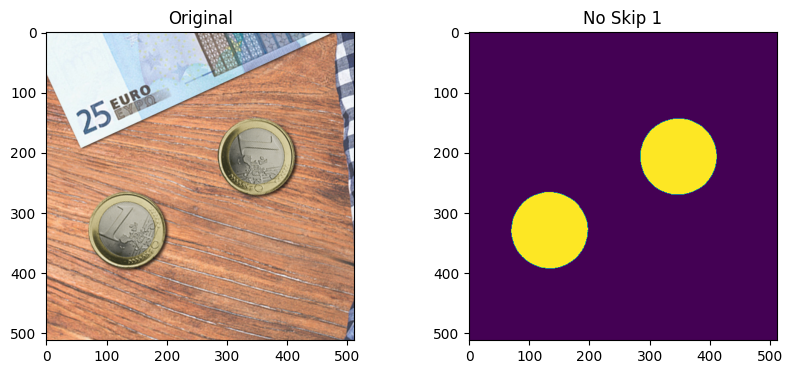

------------------------------


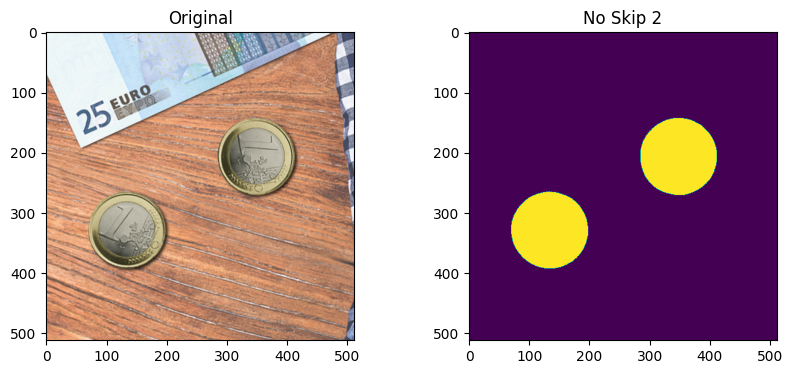

------------------------------


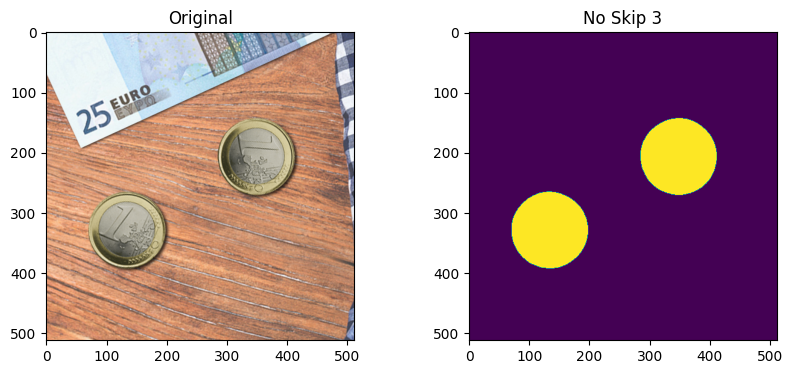

------------------------------


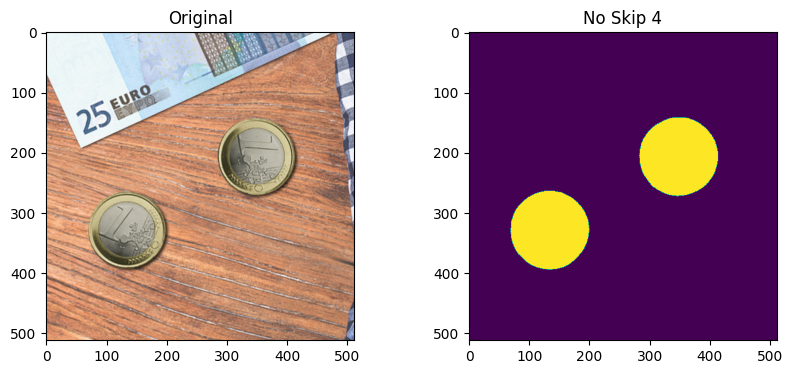

------------------------------


: 

In [ ]:
it = iter(ds_loader)
img, label = next(it)
img_device = img.to(device)

configs = [
    ("model_original", "Original", [64,128,256,512], 1024, [True,True,True,True]),
    ("model_simplified", "Simp / 2", [32,64,128,256], 512, [True,True,True,True]),
    ("model_simplified_4", "Simp / 4", [16,32,64,128], 256, [True,True,True,True]),
    ("model_simplified_8", "Simp / 8", [8,16,32,64], 128, [True,True,True,True]),
    ("model_simplified_16", "Simp / 16", [4,8,16,32], 64, [True,True,True,True]),
    ("model_simplified_32", "Simp / 32", [2,4,8,16], 32, [True,True,True,True]),
    ("model_no_skip_1", "No Skip 1", [64,128,256,512], 1024, [True,True,True,False]),
    ("model_no_skip_2", "No Skip 2", [64,128,256,512], 1024, [True,True,False,False]),
    ("model_no_skip_3", "No Skip 3", [64,128,256,512], 1024, [True,False,False,False]),
    ("model_no_skip_4", "No Skip 4", [64,128,256,512], 1024, [False,False,False,False]),
]

for file_id, label, chans, bn, skips in configs:
    model = build_unet(channels=chans, bottleneck=bn, skips=skips).to(device)
    
    model.load_state_dict(torch.load(f"{file_id}.pth", map_location=device))
    model.eval()
    
    with torch.no_grad():
        ret = torch.round(model(img_device))
    
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1); plt.imshow(img[1].permute(1,2,0).cpu()); plt.title("Original")
    plt.subplot(1, 2, 2); plt.imshow(ret[1][0].cpu()); plt.title(label)
    plt.show()
    
    del model
    torch.cuda.empty_cache()
    print("-" * 30)